In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.datasets import fashion_mnist

In [3]:
import sys
sys.path.append('../')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers

In [4]:
# Import series of helper functions for the notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves

In [5]:
# Check GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing

In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

data = {
    "Dataset Part": ["Training", "Testing"],
    "Number of Samples": [x_train.shape[0], x_test.shape[0]],
    "Image Dimensions": [x_train.shape[1:], x_test.shape[1:]],
    "Number of Classes": [y_train.shape[1], y_test.shape[1]]
}

df = pd.DataFrame(data)
print(df)

  Dataset Part  Number of Samples Image Dimensions  Number of Classes
0     Training              60000      (28, 28, 1)                 10
1      Testing              10000      (28, 28, 1)                 10


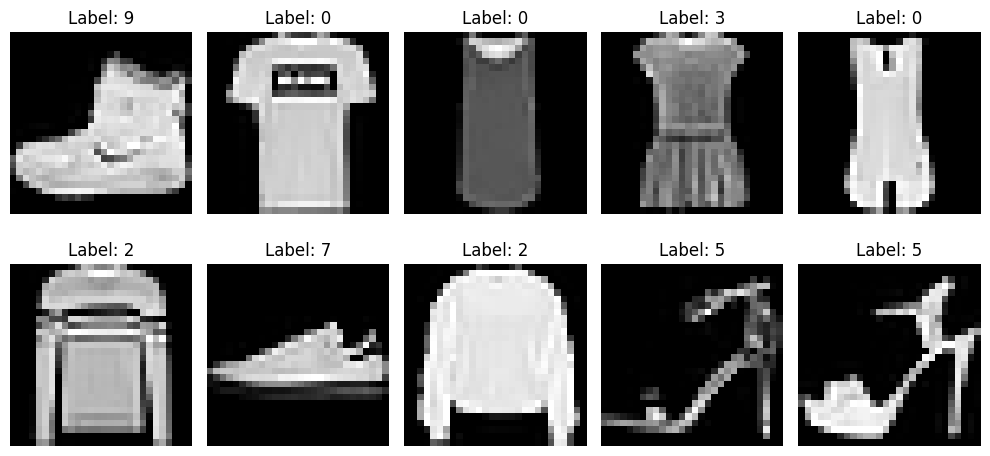

In [7]:
# Display some images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Hyperparameter

In [8]:
input_size = (28, 28, 1) # The image size of the MNIST
patch_size = (2, 2) # Segment 28-by-28 frames into 2-by-2 sized patches, patch contents and positions are embedded
n_labels = 10 # MNIST labels

# Dropout parameters
mlp_drop_rate = 0.01 # Droupout after each MLP layer
attn_drop_rate = 0.01 # Dropout after Swin-Attention
proj_drop_rate = 0.01 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
drop_path_rate = 0.01 # Drop-path within skip-connections

# Self-attention parameters 
# (Fixed for all the blocks in this configuration, but can vary per block in larger architectures)
num_heads = 8 # Number of attention heads
embed_dim = 64 # Number of embedded dimensions
num_mlp = 256 # Number of MLP nodes
qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor

# Shift-window parameters
window_size = 2 # Size of attention window (height = width)
shift_size = window_size // 2 # Size of shifting (shift_size < window_size)

num_patch_x = input_size[0]//patch_size[0]
num_patch_y = input_size[1]//patch_size[1]

## Model configuration

In [9]:
# The input section
IN = Input(input_size)
X = IN

# Extract patches from the input tensor
X = transformer_layers.patch_extract(patch_size)(X)

# Embed patches to tokens
X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)

# -------------------- Swin transformers -------------------- #
# Stage 1: window-attention + Swin-attention + patch-merging

for i in range(2):
    
    if i % 2 == 0:
        shift_size_temp = 0
    else:
        shift_size_temp = shift_size

    X = swin_layers.SwinTransformerBlock(dim=embed_dim, num_patch=(num_patch_x, num_patch_y), num_heads=num_heads, 
                             window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp, qkv_bias=qkv_bias, qk_scale=qk_scale,
                             mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate, drop_path_prob=drop_path_rate, 
                             name='swin_block{}'.format(i))(X)
# Patch-merging
# Pooling patch sequences. Half the number of patches (skip every two patches) and double the embedded dimensions
X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)

# ----------------------------------------------------------- #

# Convert embedded tokens (2D) to vectors (1D)
X = GlobalAveragePooling1D()(X)

# The output section
OUT = Dense(n_labels, activation='softmax')(X)

In [10]:
# Model configuration
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 patch_extract (patch_extrac  (None, 196, 4)           0         
 t)                                                              
                                                                 
 patch_embedding (patch_embe  (None, 196, 64)          12864     
 dding)                                                          
                                                                 
 swin_transformer_block (Swi  (None, 196, 64)          50072     
 nTransformerBlock)                                              
                                                                 
 swin_transformer_block_1 (S  (None, 196, 64)          50856     
 winTransformerBlock)                                        

In [12]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy',])

# Training
SAVE_DIR = "./logs"
model_history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1, 
                          callbacks=[create_tensorboard_callback(SAVE_DIR, "Swim_model")])

Saving TensorBoard log files to: ./logs/Swim_model/20240222-091037
Layer patch_extract has arguments ['patch_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/5
1688/1688 [==============================] - 33s 18ms/step - loss: 0.5718 - accuracy: 0.7931 - val_loss: 0.4099 - val_accuracy: 0.8488
Epoch 2/5
1688/1688 [==============================] - 31s 18ms/step - loss: 0.4251 - accuracy: 0.8464 - val_loss: 0.4171 - val_accuracy: 0.8485
Epoch 3/5
1688/1688 [==============================] - 38s 23ms/step - loss: 0.3887 - accuracy: 0.8582 - val_loss: 0.3483 - val_accuracy: 0.8688
Epoch 4/5
1688/1688 [=======================

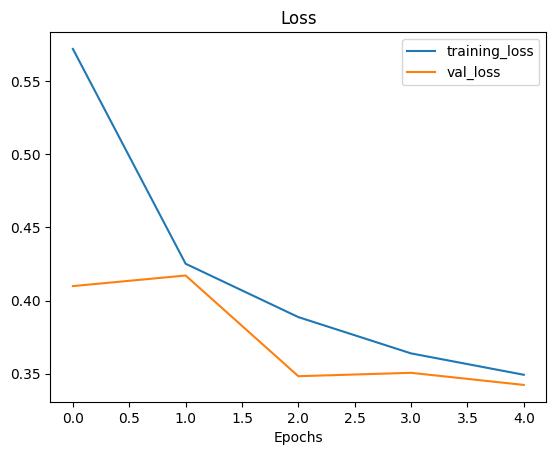

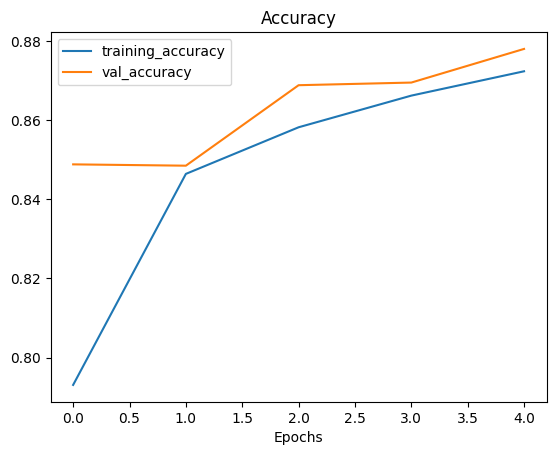

In [13]:
plot_loss_curves(model_history)
plt.show()

## Evaluate

In [14]:
# Make predictions on the validation data

model_pred_probs = model.predict(x_test)
model_pred_probs.shape, model_pred_probs[:10]

313/313 [==============================] - 2s 6ms/step


((10000, 10),
 array([[5.9148967e-08, 2.9569409e-07, 3.7634666e-07, 5.7576665e-07,
         3.8690331e-07, 3.2738552e-03, 1.2378030e-07, 2.5826307e-02,
         1.3527835e-05, 9.7088450e-01],
        [8.5617676e-03, 3.1875251e-04, 9.6105742e-01, 4.8395310e-04,
         6.0392427e-03, 9.1305833e-07, 2.3535021e-02, 3.8941270e-08,
         2.6488638e-06, 1.7804733e-07],
        [4.0254031e-06, 9.9991357e-01, 6.9211822e-08, 5.7481946e-05,
         2.4517889e-05, 3.2925016e-08, 2.6437618e-07, 1.8779511e-08,
         3.8367098e-08, 2.3380387e-09],
        [1.2133678e-07, 9.9997246e-01, 1.9557941e-08, 2.4674549e-05,
         2.7137487e-06, 1.8701254e-09, 1.3867068e-08, 1.1346216e-09,
         2.6496713e-10, 6.4383487e-10],
        [1.9198155e-01, 1.7617109e-03, 8.8873155e-02, 7.7885552e-04,
         4.8578490e-02, 2.3788683e-08, 6.6796958e-01, 1.9033651e-08,
         5.6598001e-05, 1.0838038e-08],
        [4.1774463e-05, 9.9980253e-01, 3.3385754e-06, 1.4525044e-05,
         1.2646233e-04, 6.0

In [15]:
# Convert prediction probabilities to prediction classes

model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

    # Convert one-hot encoded labels to class labels
    y_true_classes = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    y_pred_classes = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
    
    # Calculate model precision, recall, and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [17]:
model_results = calculate_results(y_true=y_test, y_pred=model_preds)
model_results

{'accuracy': 85.74000000000001,
 'precision': 0.8657569836450937,
 'recall': 0.8574,
 'f1': 0.8574153778578951}